In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

df_eddies = pd.read_pickle('/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/Eddy_Data/df_eddies_processed_1462_10650.pkl')
df_tilt_data = pd.read_pickle("/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/Eddy_Data/Vertical_Eddy_Dataset/df_tilt_data.pkl")
df_eddies = df_eddies.merge(
    df_tilt_data[['Eddy', 'Day', 'TiltDis', 'TiltDir']],
    how='left',
    left_on=['Eddy', 'Day'],
    right_on=['Eddy', 'Day']
)

with open('/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/Eddy_Data/Vertical_Eddy_Dataset/dic_vert_eddies.pkl', 'rb') as f:
    dic_eddies_vert = pickle.load(f)
    
import sys
sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules") 
from utils import smooth
    

In [2]:
import netCDF4 as nc
from scipy.interpolate import griddata
import netCDF4 as nc
from scipy.interpolate import RegularGridInterpolator

fname = f'/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
dataset = nc.Dataset(fname)
lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
mask_rho = np.transpose(dataset.variables['mask_rho'], axes=(1, 0))
h =  np.transpose(dataset.variables['h'], axes=(1, 0))
angle = dataset.variables['angle'][0, 0]
z_r = np.load('/srv/scratch/z5297792/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))#[150, 150, :]
def distance(lat1, lon1, lat2, lon2):
    EARTH_RADIUS = 6357
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return EARTH_RADIUS * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
j_mid = lon_rho.shape[1] // 2
i_mid = lon_rho.shape[0] // 2
dx = distance(lat_rho[:-1, j_mid], lon_rho[:-1, j_mid],
              lat_rho[1:, j_mid], lon_rho[1:, j_mid])
dy = distance(lat_rho[i_mid, :-1], lon_rho[i_mid, :-1],
              lat_rho[i_mid, 1:], lon_rho[i_mid, 1:])
x_grid = np.insert(np.cumsum(dx), 0, 0)
y_grid = np.insert(np.cumsum(dy), 0, 0)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid, indexing='ij')
                             

In [3]:
sample_eddies = [66, 425, 871, 1780, 31, 182, 1602, 2128]
dic_sample = {}
for eddy in sample_eddies:
    eddy = f'Eddy{eddy}'
    dic_sample[eddy] = dic_eddies_vert[eddy]
    

In [4]:
mask = np.abs(z_r[150, 150, :]) < 1000
depth = np.abs(z_r[150, 150, :][mask])
n = depth.size

base = pd.DataFrame({"Depth": depth})
frames = []

for eddy, dic in dic_sample.items():
    for d, (df, day) in enumerate(zip(dic.values(), dic.keys())):
        if df.empty:
            continue
        day = int(day[3:])
        df2 = df.loc[df["Depth"].abs() < 1000, ["x", "y"]].reset_index(drop=True)
        tmp = df2.reindex(range(n))  # pad with NaNs to match depth levels
        tmp.columns = [f"{eddy}_Day{day}_x", f"{eddy}_Day{day}_y"]
        frames.append(tmp)

df_depths = pd.concat([base, *frames], axis=1, copy=False)
df_depths


,Depth,Eddy66_Day1674_x,Eddy66_Day1674_y,Eddy66_Day1675_x,Eddy66_Day1675_y,Eddy66_Day1676_x,Eddy66_Day1676_y,Eddy66_Day1679_x,Eddy66_Day1679_y,Eddy66_Day1680_x,...,Eddy2128_Day8966_x,Eddy2128_Day8966_y,Eddy2128_Day8967_x,Eddy2128_Day8967_y,Eddy2128_Day8968_x,Eddy2128_Day8968_y,Eddy2128_Day8969_x,Eddy2128_Day8969_y,Eddy2128_Day8970_x,Eddy2128_Day8970_y
0,1.783320,838.082945,1463.359042,841.944207,1458.453989,845.647270,1457.132245,844.231507,1488.502854,839.416705,...,253.084486,567.480090,241.881085,536.699813,238.604963,523.279677,240.586005,517.400123,242.627058,498.439709
1,5.879627,838.449025,1462.889245,842.548504,1458.370782,846.492748,1457.401894,844.139211,1487.952266,839.914092,...,247.609623,560.154560,240.715586,532.490102,238.290099,522.534501,239.280399,516.258631,243.434436,499.768934
2,10.725783,838.490020,1462.700349,842.953076,1458.517750,846.865130,1457.608137,844.148262,1487.665062,840.245640,...,246.281557,545.042801,240.745331,532.123683,238.367262,522.731495,239.246365,516.226479,243.800521,500.998354
3,16.383097,838.643865,1462.945791,843.346376,1458.755273,847.123878,1457.839066,844.146417,1487.423538,840.456378,...,243.799958,535.565244,240.616023,531.272790,238.396574,522.900646,239.201841,516.231714,243.843124,502.265386
4,22.925581,838.758631,1462.524487,843.581149,1458.630220,847.346424,1458.110049,844.146634,1487.093842,840.741524,...,243.910670,532.647053,240.598377,530.937821,238.286392,522.686191,239.195147,516.253579,243.571661,503.336370
5,30.444118,838.899192,1462.704843,843.973783,1459.065805,848.195131,1460.480151,844.096139,1486.861545,840.803457,...,243.769833,530.865328,240.644250,530.863947,238.164996,522.375225,239.006638,516.161120,243.011629,503.642985
6,39.052712,839.117184,1462.531297,844.352940,1459.700432,848.259160,1462.114486,844.007418,1486.672237,840.963613,...,243.670698,529.715716,240.596766,530.618297,238.173968,522.198867,238.825620,516.215450,242.030140,503.900624
7,48.897638,839.480305,1462.474008,844.380259,1461.188048,848.335503,1462.858759,843.788228,1486.529163,841.421390,...,243.619169,529.028098,240.506829,530.299263,238.209823,522.420784,238.481207,516.020812,241.513391,503.474732
8,60.170639,840.037014,1462.728148,844.866533,1462.552153,848.400615,1465.279241,843.360048,1486.256158,841.036146,...,243.535369,528.354243,240.444449,530.076358,238.148097,522.564441,238.168532,515.534681,241.119982,502.661505
9,73.127842,841.301853,1463.629237,845.664766,1464.587517,848.068300,1469.311099,842.087392,1485.073831,842.182898,...,243.429020,527.584898,240.481575,530.022219,237.992685,522.612111,238.053530,515.256108,240.797998,502.139416


## Temperature

In [5]:
def add_center_temp_columns(
    df_depths,
    df_eddies,
    X_grid,
    Y_grid,
    mask_rho,
    z_r,
    varname="temp",
    depth_max=1000,
    clim_path="/srv/scratch/z5297792/Climatology/temp_ave_not_interpolated.npy",
):
    X = np.asarray(X_grid)
    Y = np.asarray(Y_grid)
    wet = np.asarray(mask_rho).astype(bool)
    shp = X.shape

    # target depths (1D)
    if "Depth" in df_depths.columns:
        depth_all = np.abs(df_depths["Depth"].to_numpy(dtype=float))
    elif "z" in df_depths.columns:
        depth_all = np.abs(df_depths["z"].to_numpy(dtype=float))
    else:
        zr = np.abs(np.asarray(z_r, float))
        zr = np.where(wet[:, :, None], zr, np.nan)
        depth_all = np.nanmedian(zr, axis=(0, 1))

    depth_all = np.asarray(depth_all, float)
    keep = np.isfinite(depth_all) & (depth_all <= depth_max)
    depth = depth_all[keep]
    n = depth.size

    # load sigma climatology (x,y,s) (assumed aligned with your grid + s_rho)
    temp_ave = np.load(clim_path)
    temp_ave = np.asarray(temp_ave, float)
    if temp_ave.shape[:2] != shp:
        raise ValueError(f"temp_ave shape {temp_ave.shape} incompatible with X/Y shape {shp}")

    # nearest wet (i,j)
    Xf = X[wet].ravel()
    Yf = Y[wet].ravel()
    wet_idx = np.flatnonzero(wet)

    try:
        from scipy.spatial import cKDTree
        tree = cKDTree(np.c_[Xf, Yf])

        def nearest_ij(xc, yc):
            _, k = tree.query([xc, yc])
            return np.unravel_index(wet_idx[k], shp)
    except Exception:
        def nearest_ij(xc, yc):
            d2 = (Xf - xc) ** 2 + (Yf - yc) ** 2
            k = int(np.nanargmin(d2))
            return np.unravel_index(wet_idx[k], shp)

    # only compute if TiltDis exists
    valid_pairs = set(
        df_eddies.loc[~df_eddies["TiltDis"].isna(), ["Eddy", "Day"]]
        .itertuples(index=False, name=None)
    )

    key2fname = (
        df_eddies[["Eddy", "Day", "fname"]]
        .dropna(subset=["fname"])
        .drop_duplicates(["Eddy", "Day"])
        .set_index(["Eddy", "Day"])["fname"]
    )

    # abs depth of sigma surfaces: (x,y,s)
    zr_abs = np.abs(np.asarray(z_r, float))
    zr_abs = np.where(wet[:, :, None], zr_abs, np.nan)

    temp_cache = {}
    cols = {}

    def interp_profile_at_depth(zprof, vprof, d):
        zprof = np.asarray(zprof, float).ravel()
        vprof = np.asarray(vprof, float).ravel()
        m = np.isfinite(zprof) & np.isfinite(vprof)
        if m.sum() == 0:
            return np.nan
        if m.sum() == 1:
            return float(vprof[m][0])

        z = zprof[m]
        v = vprof[m]
        o = np.argsort(z)
        z = z[o]
        v = v[o]

        if d <= z[0]:
            return float(v[0])
        if d >= z[-1]:
            return float(v[-1])
        return float(np.interp(d, z, v))

    for col in df_depths.columns:
        if not col.endswith("_x"):
            continue

        base = col[:-2]
        ycol = base + "_y"
        out_temp = base + "_temp"
        out_anom = base + "_temp_anom"

        try:
            eddy = int(base.split("_Day")[0].replace("Eddy", ""))
            day = int(base.split("_Day")[1])
        except Exception:
            continue

        if (eddy, day) not in valid_pairs:
            continue
        if (eddy, day) not in key2fname.index:
            continue

        fname = str(key2fname.loc[(eddy, day)])
        fnumber = int(fname[-8:-3])
        base_day = fnumber + 1
        t_idx = int(day - base_day)

        if fname not in temp_cache:
            ds = nc.Dataset(fname)
            tempv = ds.variables[varname]
            temp_arr = np.transpose(tempv, axes=(3, 2, 1, 0))  # -> (x,y,s,t)
            temp_arr = np.flip(temp_arr, axis=2)
            temp_arr = np.where(wet[:, :, None, None], temp_arr, np.nan)
            temp_cache[fname] = temp_arr
            ds.close()

        temp = temp_cache[fname]
        if t_idx < 0 or t_idx >= temp.shape[3]:
            continue

        xs = df_depths[col].to_numpy(dtype=float)[keep]
        ys = df_depths[ycol].to_numpy(dtype=float)[keep]

        vals_temp = np.full(n, np.nan)
        vals_anom = np.full(n, np.nan)

        kk = np.flatnonzero(np.isfinite(xs) & np.isfinite(ys) & np.isfinite(depth))

        for k in kk:
            i, j = nearest_ij(xs[k], ys[k])

            zprof = zr_abs[i, j, :]
            tprof = temp[i, j, :, t_idx]
            cprof = temp_ave[i, j, :]

            t_at_d = interp_profile_at_depth(zprof, tprof, depth[k])
            c_at_d = interp_profile_at_depth(zprof, cprof, depth[k])

            vals_temp[k] = t_at_d
            vals_anom[k] = t_at_d - c_at_d if np.isfinite(t_at_d) and np.isfinite(c_at_d) else np.nan

        cols[out_temp] = vals_temp
        cols[out_anom] = vals_anom

    df_temps = pd.concat(
        [pd.DataFrame({"Depth": depth}), pd.DataFrame(cols)],
        axis=1
    )
    return df_temps



In [6]:
df_temps = add_center_temp_columns(
    df_depths,
    df_eddies,
    X_grid,
    Y_grid,
    mask_rho,
    z_r,
    varname="temp",
    depth_max=1000,
    clim_path="/srv/scratch/z5297792/Climatology/temp_ave_not_interpolated.npy"
)


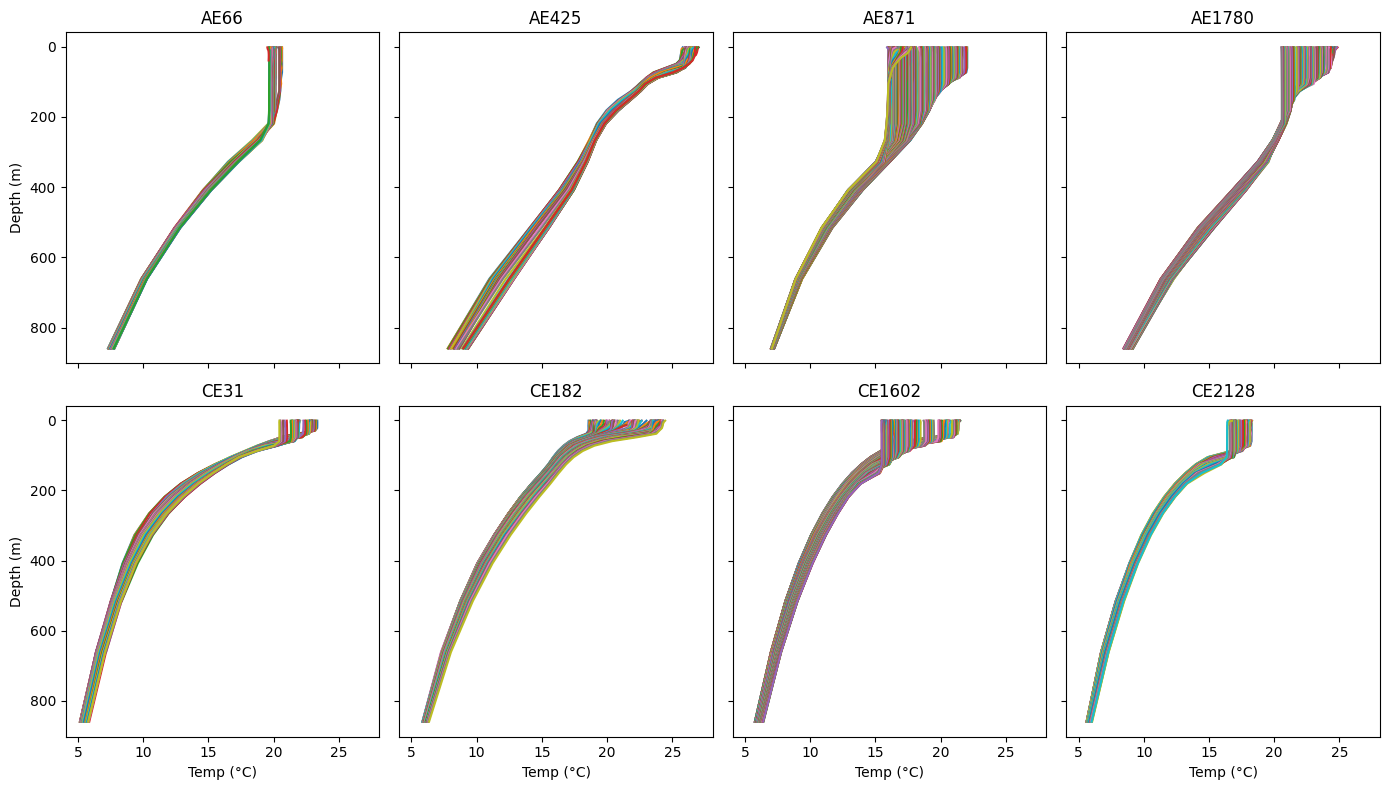

In [7]:
fig, axs = plt.subplots(2, 4, sharey=True, sharex=True, figsize=(14,8))
axs = axs.flatten()
for k, n2col in enumerate(df_temps.columns):
    if k != 0:
        eddy_id = int(n2col.split("_")[0].replace("Eddy", ""))
        p = np.where([eddy_id==i for i in sample_eddies])[0][0]
        if n2col.endswith("_temp"):
            axs[p].plot(df_temps[f'{n2col}'], df_temps.Depth)
        cyc = df_eddies[df_eddies.Eddy==eddy_id].Cyc.iloc[0]
        axs[p].set_title(f'{cyc}{eddy_id}')
axs[0].invert_yaxis()
for a, ax in enumerate(axs.flatten()):
    if a >= 4:
        ax.set_xlabel('Temp (°C)')
axs[0].set_ylabel('Depth (m)'); axs[4].set_ylabel('Depth (m)');
plt.tight_layout()


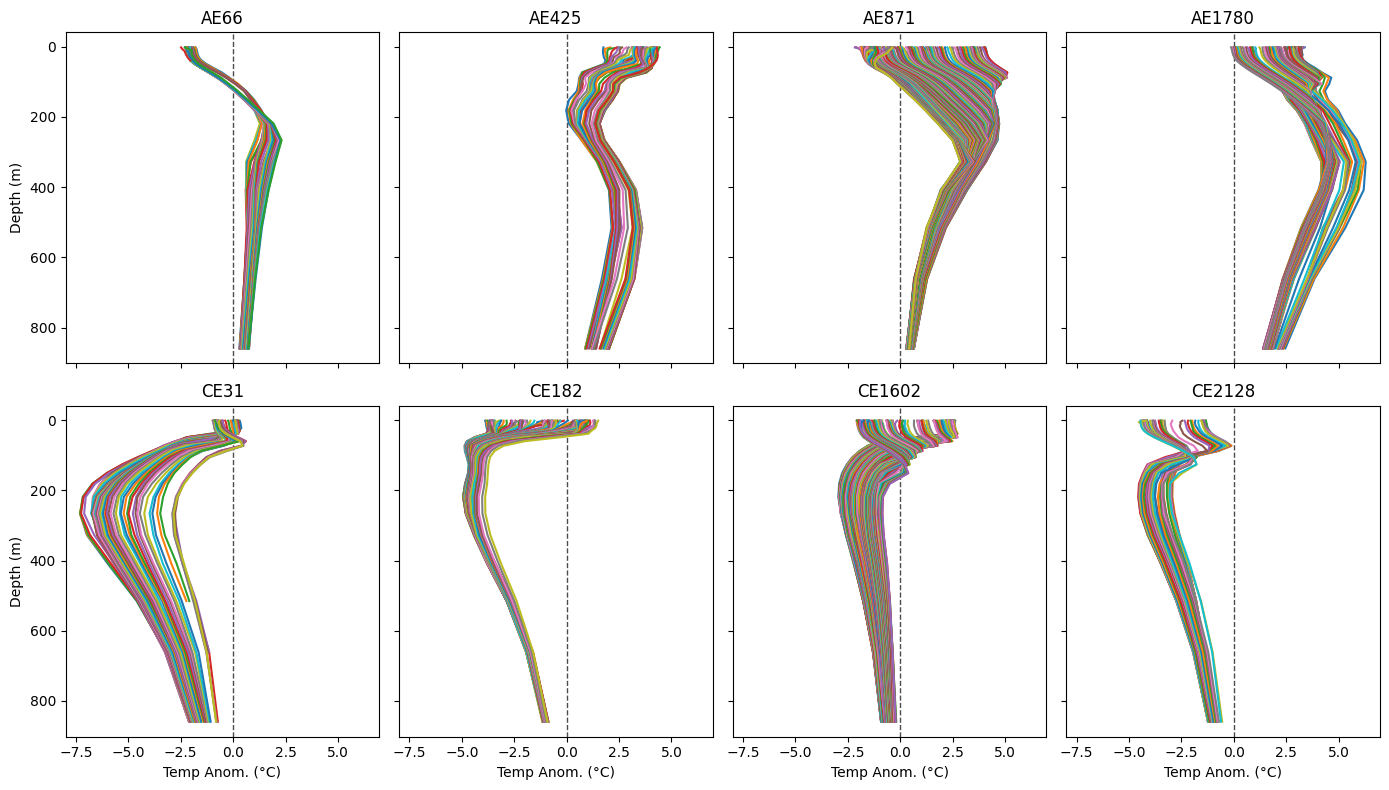

In [8]:
fig, axs = plt.subplots(2, 4, sharey=True, sharex=True, figsize=(14,8))
axs = axs.flatten()
for k, n2col in enumerate(df_temps.columns):
    if k !=0:
        eddy_id = int(n2col.split("_")[0].replace("Eddy", ""))
        p = np.where([eddy_id==i for i in sample_eddies])[0][0]
        if n2col.endswith("_temp_anom"):
            axs[p].plot(df_temps[f'{n2col}'], df_temps.Depth)
        cyc = df_eddies[df_eddies.Eddy==eddy_id].Cyc.iloc[0]
        axs[p].set_title(f'{cyc}{eddy_id}')
axs[0].invert_yaxis()
for a, ax in enumerate(axs.flatten()):
    ax.axvline(0, lw=1, alpha=.7, ls='--', zorder=-1, color='k')
    if a >= 4:
        ax.set_xlabel('Temp Anom. (°C)')
axs[0].set_ylabel('Depth (m)'); axs[4].set_ylabel('Depth (m)');
plt.tight_layout()


In [9]:
day_idx_p = [26, 17, 5, 51, 
             68, 89, 114, 40]
colors = [c for i, c in enumerate(plt.get_cmap("tab10").colors) if i != 7]


In [10]:
def quad_solver_x(xc, yc, q11, q12, q22, Rc, y0):
    a = q11
    b = -2*q11*xc + 2*q12*(y0 - yc)
    c = q11*xc**2 - 2*q12*xc*(y0 - yc) + q22*(y0 - yc)**2 - Rc**2/2

    disc = b*b - 4*a*c
    root1 = np.where(disc >= 0, (-b - np.sqrt(disc)) / (2*a), np.nan)
    root2 = np.where(disc >= 0, (-b + np.sqrt(disc)) / (2*a), np.nan)
    return root1, root2

def quad_solver_y(xc, yc, q11, q12, q22, Rc, x0):
    a = q22
    b = 2*q12*(x0 - xc)
    c = q11*(x0 - xc)**2 - Rc**2/2

    disc = b*b - 4*a*c
    dy1 = np.where(disc >= 0, (-b - np.sqrt(disc)) / (2*a), np.nan)
    dy2 = np.where(disc >= 0, (-b + np.sqrt(disc)) / (2*a), np.nan)
    return yc + dy1, yc + dy2
    

/scratch/pbs.7517277.kman.restech.unsw.edu.au/ipykernel_4149937/1326891384.py:7: RuntimeWarning: invalid value encountered in sqrt
  root1 = np.where(disc >= 0, (-b - np.sqrt(disc)) / (2*a), np.nan)
/scratch/pbs.7517277.kman.restech.unsw.edu.au/ipykernel_4149937/1326891384.py:8: RuntimeWarning: invalid value encountered in sqrt
  root2 = np.where(disc >= 0, (-b + np.sqrt(disc)) / (2*a), np.nan)
/scratch/pbs.7517277.kman.restech.unsw.edu.au/ipykernel_4149937/1326891384.py:7: RuntimeWarning: invalid value encountered in sqrt
  root1 = np.where(disc >= 0, (-b - np.sqrt(disc)) / (2*a), np.nan)
/scratch/pbs.7517277.kman.restech.unsw.edu.au/ipykernel_4149937/1326891384.py:8: RuntimeWarning: invalid value encountered in sqrt
  root2 = np.where(disc >= 0, (-b + np.sqrt(disc)) / (2*a), np.nan)


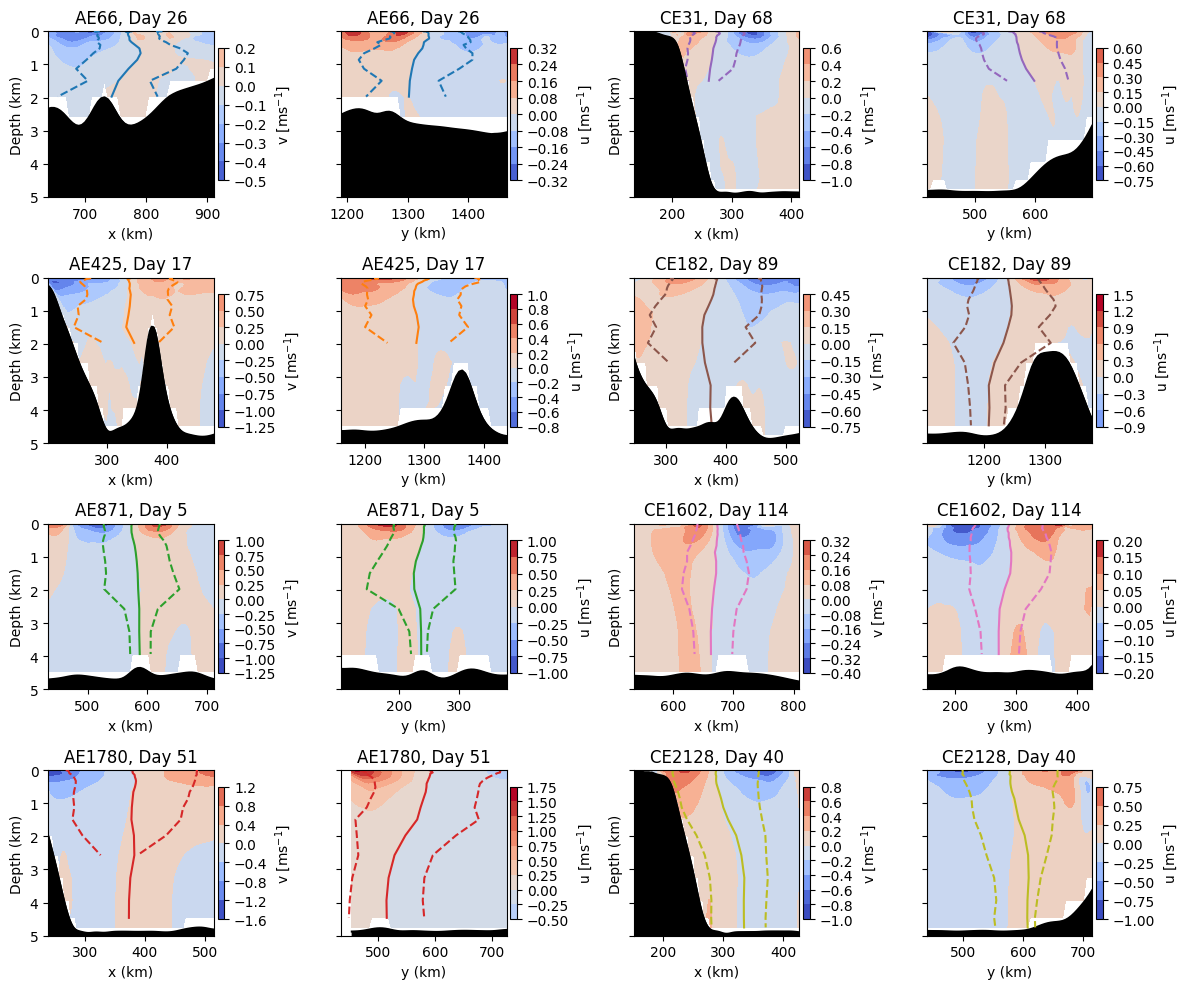

In [11]:
fig, axs = plt.subplots(4, 4, figsize=(12,10), sharey=True)
# colors = plt.get_cmap('tab10').colors
fnumber_old = None

for e, (eddy, day_idx) in enumerate(zip(sample_eddies, day_idx_p)):
    
    ax0 = axs[e % 4, (e//4)*2]
    ax1 = axs[e % 4, 1+(e//4)*2]
    r = 140 if eddy != 1978 else 200

    cyc = df_eddies[df_eddies.Eddy==eddy].iloc[0].Cyc
    
    dic = dic_sample[f'Eddy{eddy}']
    day = list(dic.keys())[day_idx]
    df = dic[day].copy()

    ax0.set_title(f'{cyc}{eddy}, Day {int(day[3:])-df_eddies[df_eddies.Eddy==eddy].iloc[0].Day}')
    ax1.set_title(f'{cyc}{eddy}, Day {int(day[3:])-df_eddies[df_eddies.Eddy==eddy].iloc[0].Day}')

    wdw = 50
    Rcs = df.Rc.values.copy()
    depths = -df.Depth.values.copy() / 1000  # in km
    df['sRc']   = smooth(Rcs, depths, window=wdw, num=1000)
    Qs = df['Q'].values.copy()
    sq11  = smooth([q[0,0] for q in Qs], depths, num=1000, window=wdw)
    sq12  = smooth([q[0,1] for q in Qs], depths, num=1000, window=wdw)
    sq22  = smooth([q[1,1] for q in Qs], depths, num=1000, window=wdw)
    df['sQ'] = [np.array([[sq11[i], sq12[i]], [sq12[i], sq22[i]]]) for i in range(len(sq11))]
    
    day = int(day[3:])
        
    fname = df_eddies[(df_eddies.Eddy==eddy)&(df_eddies['Day']==day)].iloc[0]['fname']
    fnumber = fname[-8:-3]
    if fnumber != fnumber_old:
    
        u_raw = np.load('/srv/scratch/z5297792/Climatology/u_v/u_' + fnumber + '.npy')
        v_raw = np.load('/srv/scratch/z5297792/Climatology/u_v/v_' + fnumber + '.npy')
        
        u_raw = np.where(np.abs(u_raw) > 1e30, np.nan, u_raw).astype(float)
        v_raw = np.where(np.abs(v_raw) > 1e30, np.nan, v_raw).astype(float)
        
        with nc.Dataset(fname) as dataset:
            ocean_time = dataset.variables['ocean_time'][:].data / 86400
        fnumber_old = fnumber
    t_rel = np.where(ocean_time == day)[0][0]
    
    u_t, v_t = u_raw[:, :, :, t_rel], v_raw[:, :, :, t_rel]
    
    xc_surf, yc_surf = df.iloc[0].x, df.iloc[0].y
    ic = np.where(np.abs(x_grid-xc_surf)==np.min(np.abs(x_grid-xc_surf)))[0][0]
    jc = np.where(np.abs(y_grid-yc_surf)==np.min(np.abs(y_grid-yc_surf)))[0][0]
    
    x_mask = np.where(np.abs(x_grid - xc_surf) < r)[0]
    y_mask = np.where(np.abs(y_grid - yc_surf) < r)[0]
    
    # symmetric limits
    vmax_v = np.nanmax(np.abs(v_t[x_mask, jc, :]))
    vmax_u = np.nanmax(np.abs(u_t[ic, y_mask, :]))
    
    # v‐slice
    im0 = ax0.contourf(
        x_grid[x_mask],
        -z_r[150,150,:]/1000,
        v_t[x_mask, jc, :].T,
        cmap='coolwarm',
        vmin=-vmax_v,
        vmax=+vmax_v,
        zorder=0
    )
    ax0.plot(df.x, df.Depth.abs()/1e3, color=colors[e%len(colors)])
    ##### max tang contour ################################
    root1_x, root2_x = [], []
    for k in range(len(df)):
        data = df.iloc[k]
        root1, root2 = quad_solver_x(data.x, data.y,
                                       data.sQ[0,0], data.sQ[1,0], data.sQ[1,1],
                                       data.sRc, y_grid[jc])
        root1_x.append(root1); root2_x.append(root2)
    ax0.plot(root1_x, df.Depth.abs()/1e3, color=colors[e%len(colors)], ls='--', 
             zorder=1 if df.iloc[-1].y > y_grid[jc] else 3)
    ax0.plot(root2_x, df.Depth.abs()/1e3, color=colors[e%len(colors)], ls='--',
             zorder=1 if df.iloc[-1].y > y_grid[jc] else 3)
    #########################################################
    ax0.set_xlabel('x (km)')
    ax0.set_ylabel('Depth (km)')
    ax0.plot(x_grid[x_mask], h[x_mask, jc]/1000, 'k', zorder=2)
    ax0.fill_between(x_grid[x_mask], h[x_mask, jc]/1000, 10, color='k', zorder=2)
    ax0.set_ylim(ax0.get_ylim())
    
    # vertical colourbar on the right
    cbar0 = fig.colorbar(
        im0,
        ax=ax0,
        orientation='vertical',  # default but explicit here
        pad=0.02,                # small gap to the right
        shrink=0.8               # scale to fit subplot height
    )
    cbar0.set_label(r'v [ms$^{-1}$]')
    
    # u‐slice
    im1 = ax1.contourf(
        y_grid[y_mask],
        -z_r[150,150,:]/1000,
        u_t[ic, y_mask, :].T,
        cmap='coolwarm',
        vmin=-vmax_u,
        vmax=+vmax_u,
        zorder=0
    )
    ax1.plot(df.y, df.Depth.abs()/1e3, color=colors[e])
    ##### max tang contour ################################
    root1_y, root2_y = [], []
    for k in range(len(df)):
        data = df.iloc[k]
        root1, root2 = quad_solver_y(data.x, data.y,
                                       data.sQ[0,0], data.sQ[1,0], data.sQ[1,1],
                                       data.sRc, x_grid[ic])
        root1_y.append(root1); root2_y.append(root2)
    ax1.plot(root1_y, df.Depth.abs()/1e3, color=colors[e%len(colors)], ls='--', 
             zorder=1 if df.iloc[-1].x < x_grid[ic] else 3)
    ax1.plot(root2_y, df.Depth.abs()/1e3, color=colors[e%len(colors)], ls='--',
             zorder=1 if df.iloc[-1].x < x_grid[ic] else 3)
    #########################################################
    ax1.set_xlabel('y (km)')
    ax1.plot(y_grid[y_mask], h[ic, y_mask]/1000, 'k', zorder=2)
    ax1.fill_between(y_grid[y_mask], h[ic, y_mask]/1000, 10, color='k', zorder=2)
    ax1.set_ylim(0, 5)
    
    # vertical colourbar on the right
    cbar1 = fig.colorbar(
        im1,
        ax=ax1,
        orientation='vertical',
        pad=0.02,
        shrink=0.8
    )
    cbar1.set_label(r'u [ms$^{-1}$]')

# invert y once at the end
axs[0,0].invert_yaxis()
plt.tight_layout()
plt.show()


In [12]:
def plot_temp(zlim=5):
    fig, axs = plt.subplots(4, 4, figsize=(12, 10), sharey=True)
    fnumber_old = None
    temp_cache = {}
    wet = np.asarray(mask_rho).astype(bool)
    
    temp_ave = np.load("/srv/scratch/z5297792/Climatology/temp_ave_not_interpolated.npy")
    
    for e, (eddy, day_idx) in enumerate(zip(sample_eddies, day_idx_p)):
    
        ax0 = axs[e % 4, (e // 4) * 2]
        ax1 = axs[e % 4, 1 + (e // 4) * 2]
        r = 140 if eddy not in [1978, 1780] else 200
    
        cyc = df_eddies[df_eddies.Eddy == eddy].iloc[0].Cyc
    
        dic = dic_sample[f"Eddy{eddy}"]
        day = list(dic.keys())[day_idx]
        df = dic[day].copy()
    
        rel_day = int(day[3:]) - df_eddies[df_eddies.Eddy == eddy].iloc[0].Day
        ax0.set_title(f"{cyc}{eddy}, Day {rel_day}")
        ax1.set_title(f"{cyc}{eddy}, Day {rel_day}")
    
        wdw = 50
        Rcs = df.Rc.values.copy()
        depths = -df.Depth.values.copy() / 1000  # in km
        df['sRc']   = smooth(Rcs, depths, window=wdw, num=1000)
        Qs = df['Q'].values.copy()
        sq11  = smooth([q[0,0] for q in Qs], depths, num=1000, window=wdw)
        sq12  = smooth([q[0,1] for q in Qs], depths, num=1000, window=wdw)
        sq22  = smooth([q[1,1] for q in Qs], depths, num=1000, window=wdw)
        df['sQ'] = [np.array([[sq11[i], sq12[i]], [sq12[i], sq22[i]]]) for i in range(len(sq11))]
        
        day_int = int(day[3:])
    
        fname = df_eddies[(df_eddies.Eddy == eddy) & (df_eddies["Day"] == day_int)].iloc[0]["fname"]
        fnumber = fname[-8:-3]
    
        if fnumber != fnumber_old:
            with nc.Dataset(fname) as dataset:
                ocean_time = dataset.variables["ocean_time"][:].data / 86400
            fnumber_old = fnumber
    
        t_rel = np.where(ocean_time == day_int)[0][0]
    
        if fname not in temp_cache:
            ds = nc.Dataset(fname)
            tempv = ds.variables['temp']
            temp_arr = np.transpose(tempv, axes=(3, 2, 1, 0))  # (x,y,s,t) sigma levels
            temp_arr = np.flip(temp_arr, axis=2)
            temp_arr = np.where(wet[:, :, None, None], temp_arr, np.nan)
            temp_cache[fname] = temp_arr
            ds.close()
    
        temp_t = temp_cache[fname][:, :, :, t_rel]  # (x,y,s) sigma levels at time
        temp_t -= temp_ave
    
        xc_surf, yc_surf = df.iloc[0].x, df.iloc[0].y
        ic = np.where(np.abs(x_grid - xc_surf) == np.min(np.abs(x_grid - xc_surf)))[0][0]
        jc = np.where(np.abs(y_grid - yc_surf) == np.min(np.abs(y_grid - yc_surf)))[0][0]
    
        x_mask = np.where(np.abs(x_grid - xc_surf) < r)[0]
        y_mask = np.where(np.abs(y_grid - yc_surf) < r)[0]
    
        # x–z section (sigma -> depth via z_r slice)
        vabs0 = np.nanmax(np.abs(temp_t[x_mask, jc, :]))
    
        im0 = ax0.contourf(
            np.repeat(x_grid[x_mask][:, None], 30, axis=1),
            -z_r[x_mask, jc, :] / 1000,
            temp_t[x_mask, jc, :],
            cmap="coolwarm",
            vmin=-vabs0,
            vmax=vabs0,
            zorder=0,
        )
    
        ax0.plot(df.x, -df.Depth / 1000, color=colors[e % len(colors)])
        ##### max tang contour ################################
        root1_x, root2_x = [], []
        for k in range(len(df)):
            data = df.iloc[k]
            root1, root2 = quad_solver_x(data.x, data.y,
                                           data.sQ[0,0], data.sQ[1,0], data.sQ[1,1],
                                           data.sRc, y_grid[jc])
            root1_x.append(root1); root2_x.append(root2)
        ax0.plot(root1_x, df.Depth.abs()/1e3, color=colors[e%len(colors)], ls='--', 
                 zorder=1 if df.iloc[-1].y > y_grid[jc] else 3)
        ax0.plot(root2_x, df.Depth.abs()/1e3, color=colors[e%len(colors)], ls='--',
                 zorder=1 if df.iloc[-1].y > y_grid[jc] else 3)
        #########################################################
        ax0.set_xlabel("x (km)")
        ax0.set_ylabel("Depth (km)")
        ax0.plot(x_grid[x_mask], h[x_mask, jc] / 1000, "k", zorder=2)
        ax0.fill_between(x_grid[x_mask], h[x_mask, jc] / 1000, 10, color="k", zorder=2)
        ax0.set_ylim(ax0.get_ylim())
    
        cbar0 = fig.colorbar(im0, ax=ax0, orientation="vertical", pad=0.02, shrink=0.8)
        cbar0.set_label(r"TA [$^\circ$C]")
    
        # y–z section (sigma -> depth via z_r slice)
        vabs1 = np.nanmax(np.abs(temp_t[ic, y_mask, :]))
    
        im1 = ax1.contourf(
            # y_grid[y_mask]
            np.repeat(y_grid[y_mask][:, None], 30, axis=1),
            -z_r[ic, y_mask, :] / 1000,
            temp_t[ic, y_mask, :],
            cmap="coolwarm",
            vmin=-vabs1,
            vmax=vabs1,
            zorder=0,
        )
    
        ax1.plot(df.y, -df.Depth / 1000, color=colors[e % len(colors)])
        ##### max tang contour ################################
        root1_y, root2_y = [], []
        for k in range(len(df)):
            data = df.iloc[k]
            root1, root2 = quad_solver_y(data.x, data.y,
                                           data.sQ[0,0], data.sQ[1,0], data.sQ[1,1],
                                           data.sRc, x_grid[ic])
            root1_y.append(root1); root2_y.append(root2)
        ax1.plot(root1_y, df.Depth.abs()/1e3, color=colors[e%len(colors)], ls='--', 
                 zorder=1 if df.iloc[-1].x < x_grid[ic] else 3)
        ax1.plot(root2_y, df.Depth.abs()/1e3, color=colors[e%len(colors)], ls='--',
                 zorder=1 if df.iloc[-1].x < x_grid[ic] else 3)
        #########################################################
        ax1.set_xlabel("y (km)")
        ax1.plot(y_grid[y_mask], h[ic, y_mask] / 1000, "k", zorder=2)
        ax1.fill_between(y_grid[y_mask], h[ic, y_mask] / 1000, 10, color="k", zorder=2)
        ax1.set_ylim(0, zlim)
    
        cbar1 = fig.colorbar(im1, ax=ax1, orientation="vertical", pad=0.02, shrink=0.8)
        cbar1.set_label(r"TA [$^\circ$C]")
    
    axs[0, 0].invert_yaxis()
    plt.tight_layout()
    plt.show()


/scratch/pbs.7517277.kman.restech.unsw.edu.au/ipykernel_4149937/1326891384.py:7: RuntimeWarning: invalid value encountered in sqrt
  root1 = np.where(disc >= 0, (-b - np.sqrt(disc)) / (2*a), np.nan)
/scratch/pbs.7517277.kman.restech.unsw.edu.au/ipykernel_4149937/1326891384.py:8: RuntimeWarning: invalid value encountered in sqrt
  root2 = np.where(disc >= 0, (-b + np.sqrt(disc)) / (2*a), np.nan)
/scratch/pbs.7517277.kman.restech.unsw.edu.au/ipykernel_4149937/1326891384.py:7: RuntimeWarning: invalid value encountered in sqrt
  root1 = np.where(disc >= 0, (-b - np.sqrt(disc)) / (2*a), np.nan)
/scratch/pbs.7517277.kman.restech.unsw.edu.au/ipykernel_4149937/1326891384.py:8: RuntimeWarning: invalid value encountered in sqrt
  root2 = np.where(disc >= 0, (-b + np.sqrt(disc)) / (2*a), np.nan)


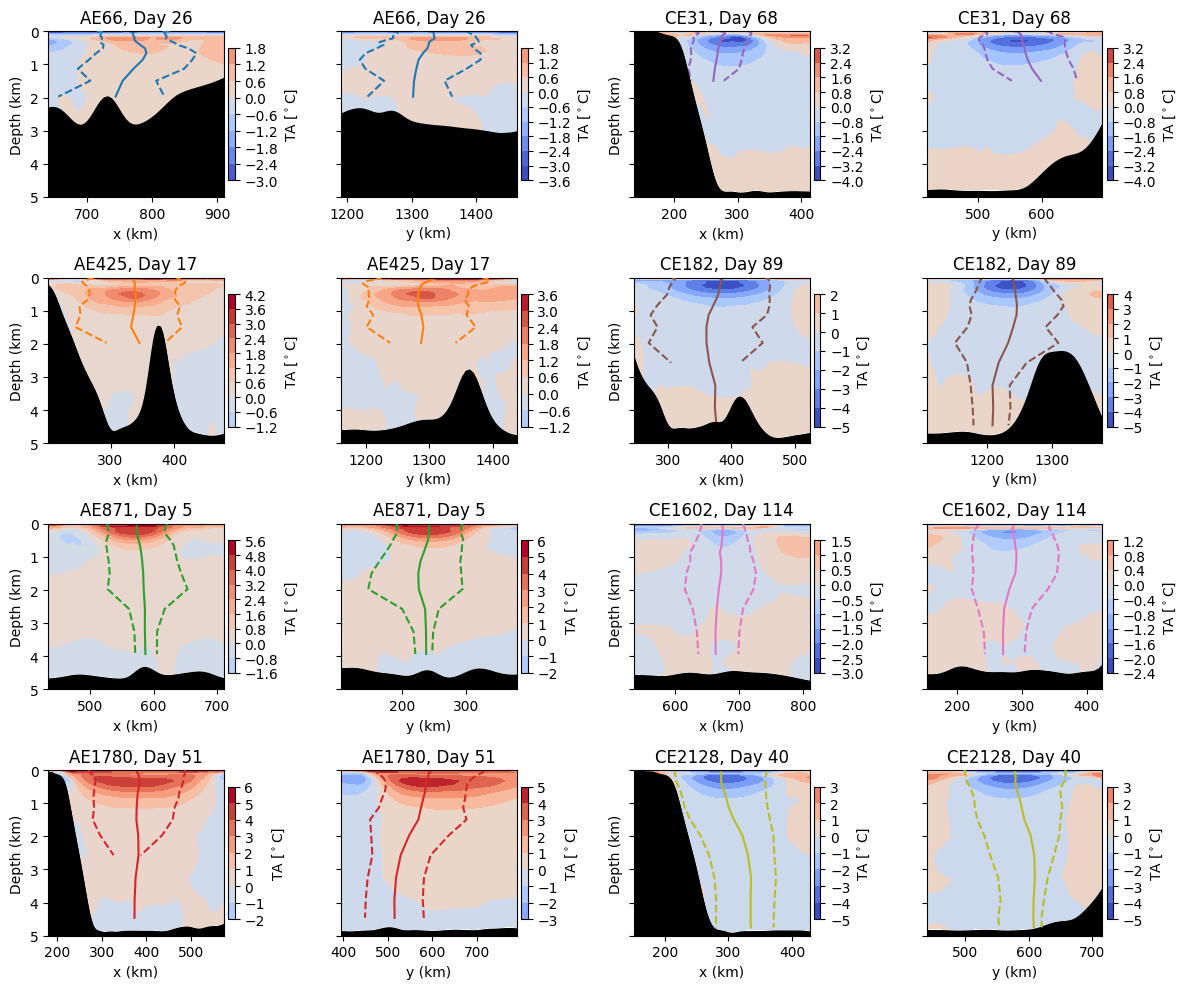

In [13]:
plot_temp()

/scratch/pbs.7517277.kman.restech.unsw.edu.au/ipykernel_4149937/1326891384.py:7: RuntimeWarning: invalid value encountered in sqrt
  root1 = np.where(disc >= 0, (-b - np.sqrt(disc)) / (2*a), np.nan)
/scratch/pbs.7517277.kman.restech.unsw.edu.au/ipykernel_4149937/1326891384.py:8: RuntimeWarning: invalid value encountered in sqrt
  root2 = np.where(disc >= 0, (-b + np.sqrt(disc)) / (2*a), np.nan)
/scratch/pbs.7517277.kman.restech.unsw.edu.au/ipykernel_4149937/1326891384.py:7: RuntimeWarning: invalid value encountered in sqrt
  root1 = np.where(disc >= 0, (-b - np.sqrt(disc)) / (2*a), np.nan)
/scratch/pbs.7517277.kman.restech.unsw.edu.au/ipykernel_4149937/1326891384.py:8: RuntimeWarning: invalid value encountered in sqrt
  root2 = np.where(disc >= 0, (-b + np.sqrt(disc)) / (2*a), np.nan)


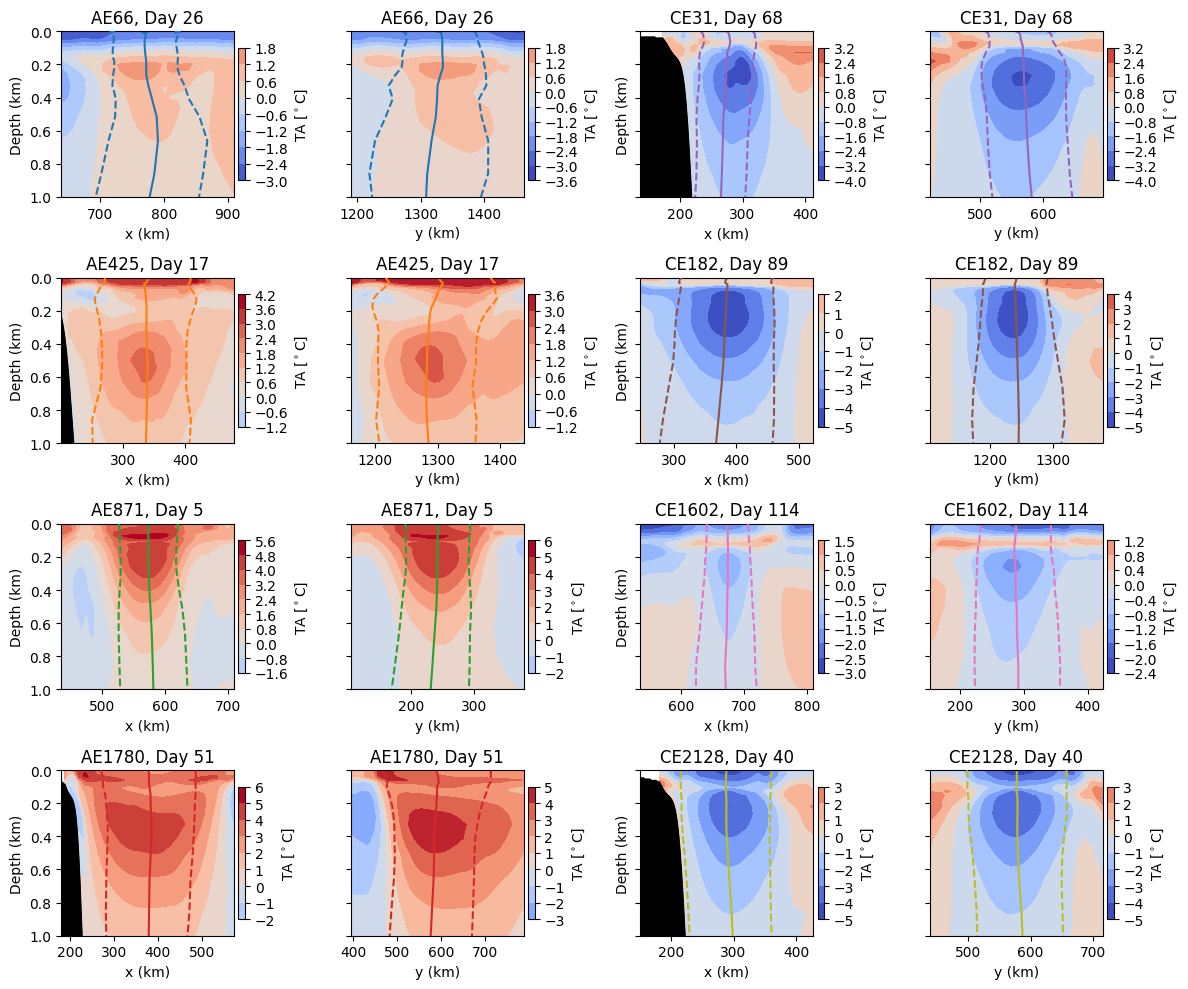

In [14]:
plot_temp(zlim=1)

In [15]:
from matplotlib.colors import TwoSlopeNorm

def extremum_path(x1d, z2d, T2d, mode="max", z_level="median"):
    # x1d: (n,), z2d: (n,k), T2d: (n,k)
    n, k = T2d.shape
    x_out = np.full(k, np.nan)
    z_out = np.full(k, np.nan)

    for kk in range(k):
        col = T2d[:, kk]
        zcol = z2d[:, kk]
        m = np.isfinite(col) & np.isfinite(zcol) & np.isfinite(x1d)
        if not np.any(m):
            continue

        # pick extremum along x at this vertical level
        ii = np.nanargmax(col[m]) if mode == "max" else np.nanargmin(col[m])
        idx = np.flatnonzero(m)[ii]
        x_out[kk] = x1d[idx]

        # force ONE depth per level (monotonic in kk)
        if z_level == "median":
            z_out[kk] = np.nanmedian(zcol[m])
        elif z_level == "mean":
            z_out[kk] = np.nanmean(zcol[m])
        else:
            z_out[kk] = zcol[idx]  # old behaviour (can wiggle)

    return x_out, z_out

def plot_temp_extrema(zlim=5):
    fig, axs = plt.subplots(4, 4, figsize=(12, 10), sharey=True)
    fnumber_old = None
    temp_cache = {}
    wet = np.asarray(mask_rho).astype(bool)

    temp_ave = np.load("/srv/scratch/z5297792/Climatology/temp_ave_not_interpolated.npy")

    for e, (eddy, day_idx) in enumerate(zip(sample_eddies, day_idx_p)):

        ax0 = axs[e % 4, (e // 4) * 2]
        ax1 = axs[e % 4, 1 + (e // 4) * 2]
        r = 140 if eddy not in [1978, 1780] else 200

        cyc = df_eddies[df_eddies.Eddy == eddy].iloc[0].Cyc

        dic = dic_sample[f"Eddy{eddy}"]
        day = list(dic.keys())[day_idx]
        df = dic[day].copy()

        rel_day = int(day[3:]) - df_eddies[df_eddies.Eddy == eddy].iloc[0].Day
        ax0.set_title(f"{cyc}{eddy}, Day {rel_day}")
        ax1.set_title(f"{cyc}{eddy}, Day {rel_day}")

        wdw = 50
        Rcs = df.Rc.values.copy()
        depths = -df.Depth.values.copy() / 1000  # in km
        df['sRc']   = smooth(Rcs, depths, window=wdw, num=1000)
        Qs = df['Q'].values.copy()
        sq11  = smooth([q[0,0] for q in Qs], depths, num=1000, window=wdw)
        sq12  = smooth([q[0,1] for q in Qs], depths, num=1000, window=wdw)
        sq22  = smooth([q[1,1] for q in Qs], depths, num=1000, window=wdw)
        df['sQ'] = [np.array([[sq11[i], sq12[i]], [sq12[i], sq22[i]]]) for i in range(len(sq11))]

        day_int = int(day[3:])

        fname = df_eddies[(df_eddies.Eddy == eddy) & (df_eddies["Day"] == day_int)].iloc[0]["fname"]
        fnumber = fname[-8:-3]

        if fnumber != fnumber_old:
            with nc.Dataset(fname) as dataset:
                ocean_time = dataset.variables["ocean_time"][:].data / 86400
            fnumber_old = fnumber

        t_rel = np.where(ocean_time == day_int)[0][0]

        if fname not in temp_cache:
            ds = nc.Dataset(fname)
            tempv = ds.variables["temp"]
            temp_arr = np.transpose(tempv, axes=(3, 2, 1, 0))  # (x,y,s,t)
            temp_arr = np.flip(temp_arr, axis=2)
            temp_arr = np.where(wet[:, :, None, None], temp_arr, np.nan)
            temp_cache[fname] = temp_arr
            ds.close()

        temp_t = temp_cache[fname][:, :, :, t_rel]  # (x,y,s)
        temp_t -= temp_ave

        xc_surf, yc_surf = df.iloc[0].x, df.iloc[0].y
        ic = np.where(np.abs(x_grid - xc_surf) == np.min(np.abs(x_grid - xc_surf)))[0][0]
        jc = np.where(np.abs(y_grid - yc_surf) == np.min(np.abs(y_grid - yc_surf)))[0][0]

        x_mask = np.where(np.abs(x_grid - xc_surf) < r)[0]
        y_mask = np.where(np.abs(y_grid - yc_surf) < r)[0]

        mode = "max" if cyc == "AE" else "min"

        # x–z
        T0 = temp_t[x_mask, jc, :]
        X0 = x_grid[x_mask]
        Z0 = -z_r[x_mask, jc, :] / 1000

        vabs0 = np.nanmax(np.abs(T0))
        im0 = ax0.contourf(
            np.repeat(X0[:, None], T0.shape[1], axis=1),
            Z0,
            T0,
            cmap="coolwarm",
            norm=TwoSlopeNorm(vmin=-vabs0, vcenter=0, vmax=vabs0),
            zorder=0,
        )

        x_ext, z_ext = extremum_path(X0, Z0, T0, mode=mode)
        ax0.plot(x_ext, z_ext, color="k", lw=1.2, zorder=2)

        ax0.plot(df.x, -df.Depth / 1000, color=colors[e % len(colors)])
        ##### max tang contour ################################
        root1_x, root2_x = [], []
        for k in range(len(df)):
            data = df.iloc[k]
            root1, root2 = quad_solver_x(data.x, data.y,
                                           data.sQ[0,0], data.sQ[1,0], data.sQ[1,1],
                                           data.sRc, y_grid[jc])
            root1_x.append(root1); root2_x.append(root2)
        ax0.plot(root1_x, df.Depth.abs()/1e3, color=colors[e%len(colors)], ls='--', 
                 zorder=1 if df.iloc[-1].y > y_grid[jc] else 3)
        ax0.plot(root2_x, df.Depth.abs()/1e3, color=colors[e%len(colors)], ls='--',
                 zorder=1 if df.iloc[-1].y > y_grid[jc] else 3)
        #########################################################

        ax0.set_xlabel("x (km)")
        ax0.set_ylabel("Depth (km)")
        ax0.plot(X0, h[x_mask, jc] / 1000, "k", zorder=2)
        ax0.fill_between(X0, h[x_mask, jc] / 1000, 10, color="k", zorder=2)
        ax0.set_ylim(ax0.get_ylim())

        cbar0 = fig.colorbar(im0, ax=ax0, orientation="vertical", pad=0.02, shrink=0.8)
        cbar0.set_label(r"TA [$^\circ$C]")

        # y–z
        T1 = temp_t[ic, y_mask, :]
        Y1 = y_grid[y_mask]
        Z1 = -z_r[ic, y_mask, :] / 1000

        vabs1 = np.nanmax(np.abs(T1))
        im1 = ax1.contourf(
            np.repeat(Y1[:, None], T1.shape[1], axis=1),
            Z1,
            T1,
            cmap="coolwarm",
            norm=TwoSlopeNorm(vmin=-vabs1, vcenter=0, vmax=vabs1),
            zorder=0,
        )

        y_ext, z_ext = extremum_path(Y1, Z1, T1, mode=mode)
        ax1.plot(y_ext, z_ext, color="k", lw=1.2, zorder=2)

        ax1.plot(df.y, -df.Depth / 1000, color=colors[e % len(colors)])
        ##### max tang contour ################################
        root1_y, root2_y = [], []
        for k in range(len(df)):
            data = df.iloc[k]
            root1, root2 = quad_solver_y(data.x, data.y,
                                           data.sQ[0,0], data.sQ[1,0], data.sQ[1,1],
                                           data.sRc, x_grid[ic])
            root1_y.append(root1); root2_y.append(root2)
        ax1.plot(root1_y, df.Depth.abs()/1e3, color=colors[e%len(colors)], ls='--', 
                 zorder=1 if df.iloc[-1].x < x_grid[ic] else 3)
        ax1.plot(root2_y, df.Depth.abs()/1e3, color=colors[e%len(colors)], ls='--',
                 zorder=1 if df.iloc[-1].x < x_grid[ic] else 3)
        #########################################################

        ax1.set_xlabel("y (km)")
        ax1.plot(Y1, h[ic, y_mask] / 1000, "k", zorder=2)
        ax1.fill_between(Y1, h[ic, y_mask] / 1000, 10, color="k", zorder=2)
        ax1.set_ylim(0, zlim)

        cbar1 = fig.colorbar(im1, ax=ax1, orientation="vertical", pad=0.02, shrink=0.8)
        cbar1.set_label(r"TA [$^\circ$C]")

    axs[0, 0].invert_yaxis()
    plt.tight_layout()
    plt.show()
    

/scratch/pbs.7517277.kman.restech.unsw.edu.au/ipykernel_4149937/1326891384.py:7: RuntimeWarning: invalid value encountered in sqrt
  root1 = np.where(disc >= 0, (-b - np.sqrt(disc)) / (2*a), np.nan)
/scratch/pbs.7517277.kman.restech.unsw.edu.au/ipykernel_4149937/1326891384.py:8: RuntimeWarning: invalid value encountered in sqrt
  root2 = np.where(disc >= 0, (-b + np.sqrt(disc)) / (2*a), np.nan)
/scratch/pbs.7517277.kman.restech.unsw.edu.au/ipykernel_4149937/1326891384.py:7: RuntimeWarning: invalid value encountered in sqrt
  root1 = np.where(disc >= 0, (-b - np.sqrt(disc)) / (2*a), np.nan)
/scratch/pbs.7517277.kman.restech.unsw.edu.au/ipykernel_4149937/1326891384.py:8: RuntimeWarning: invalid value encountered in sqrt
  root2 = np.where(disc >= 0, (-b + np.sqrt(disc)) / (2*a), np.nan)


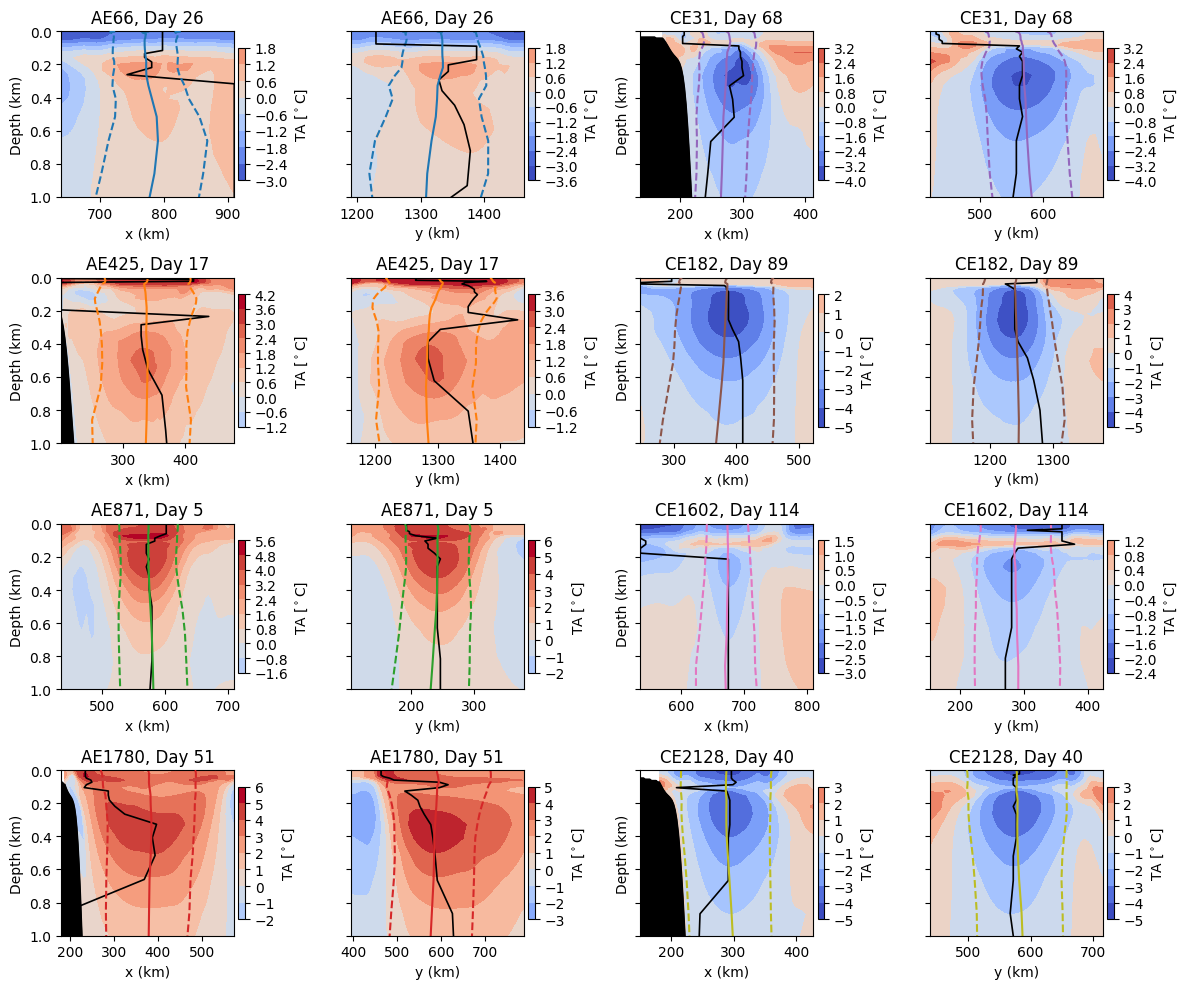

In [16]:
plot_temp_extrema(zlim=1)


/scratch/pbs.7517277.kman.restech.unsw.edu.au/ipykernel_4149937/1326891384.py:7: RuntimeWarning: invalid value encountered in sqrt
  root1 = np.where(disc >= 0, (-b - np.sqrt(disc)) / (2*a), np.nan)
/scratch/pbs.7517277.kman.restech.unsw.edu.au/ipykernel_4149937/1326891384.py:8: RuntimeWarning: invalid value encountered in sqrt
  root2 = np.where(disc >= 0, (-b + np.sqrt(disc)) / (2*a), np.nan)
/scratch/pbs.7517277.kman.restech.unsw.edu.au/ipykernel_4149937/1326891384.py:7: RuntimeWarning: invalid value encountered in sqrt
  root1 = np.where(disc >= 0, (-b - np.sqrt(disc)) / (2*a), np.nan)
/scratch/pbs.7517277.kman.restech.unsw.edu.au/ipykernel_4149937/1326891384.py:8: RuntimeWarning: invalid value encountered in sqrt
  root2 = np.where(disc >= 0, (-b + np.sqrt(disc)) / (2*a), np.nan)


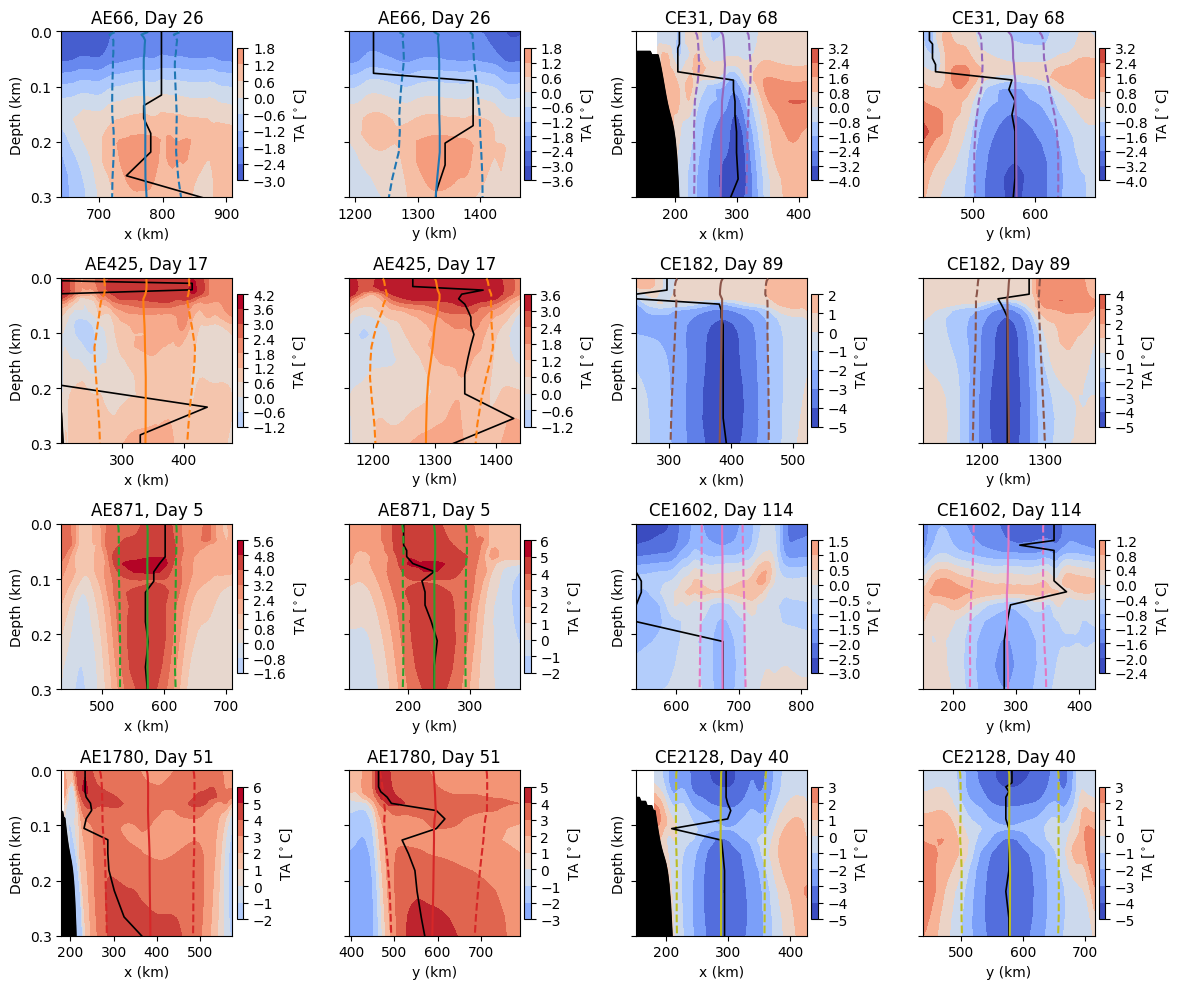

In [17]:
plot_temp_extrema(zlim=.3)
